In [2]:
%reload_ext autoreload
%autoreload 2

In [6]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
)
from ripple_heterogeneity.replay import (
    replay_run,
    replay_fig,
    replay_participation,
    replay_participation_all_replays,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
from matplotlib.ticker import AutoMinorLocator
import logging

logging.basicConfig(level=logging.INFO)


In [4]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [5]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

df = replay_run.load_results(save_path, pre_task_post=True)


In [7]:
df


,start,stop,peaks,amplitude,duration,frequency,detectorName,ripple_channel,event_spk_thres,basepath,...,traj_speed,traj_step,replay_type,pop_partic,decoding_r2,decoding_r2_pval,decoding_median_error,total_units,direction,epoch
0,7.2344,7.3312,7.2776,692.400130,0.0968,162.842051,bz_DetectSWR,76,1,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,...,830.188679,16.603774,reverse,0.317460,0.839921,0.000666,6.061843,63.0,outbound_epochs,pre_sleep
1,26.9032,27.0112,26.9368,691.066738,0.1080,153.430269,bz_DetectSWR,76,1,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,...,603.773585,12.075472,forward,0.285714,0.839921,0.000666,6.061843,63.0,outbound_epochs,pre_sleep
2,47.6952,47.8432,47.7912,851.758590,0.1480,161.080797,bz_DetectSWR,76,1,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,...,1029.649596,20.592992,reverse,0.333333,0.839921,0.000666,6.061843,63.0,outbound_epochs,pre_sleep
3,55.2992,55.3992,55.3888,416.186103,0.1000,145.450890,bz_DetectSWR,76,1,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,...,815.094340,16.301887,forward,0.222222,0.839921,0.000666,6.061843,63.0,outbound_epochs,pre_sleep
4,203.6992,203.8064,203.7792,321.720041,0.1072,185.214900,bz_DetectSWR,76,1,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,...,241.509434,4.830189,forward,0.285714,0.839921,0.000666,6.061843,63.0,outbound_epochs,pre_sleep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28742,22980.1040,22980.2368,22980.2096,1025.146015,0.1328,140.953213,bz_FindRipples,33,1,Z:\Data\Kenji\ec014.459_480,...,1452.857143,29.057143,reverse,0.255814,0.654794,0.000666,9.025425,43.0,inbound_epochs,post_sleep
28743,22993.7936,22993.8848,22993.8096,714.417520,0.0912,121.928741,bz_FindRipples,33,1,Z:\Data\Kenji\ec014.459_480,...,120.000000,2.400000,reverse,0.186047,0.654794,0.000666,9.025425,43.0,inbound_epochs,post_sleep
28744,23034.8800,23035.0272,23034.8968,1340.643335,0.1472,140.482597,bz_FindRipples,33,1,Z:\Data\Kenji\ec014.459_480,...,830.357143,16.607143,forward,0.348837,0.654794,0.000666,9.025425,43.0,inbound_epochs,post_sleep
28745,23047.6808,23047.7744,23047.7144,1034.115689,0.0936,122.388355,bz_FindRipples,33,1,Z:\Data\Kenji\ec014.459_480,...,1695.000000,33.900000,forward,0.209302,0.654794,0.000666,9.025425,43.0,inbound_epochs,post_sleep


In [18]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
save_path_cur_analysis = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_task_post"
)
batch_analysis.run(
    df,
    save_path_cur_analysis,
    replay_participation_all_replays.run,
    parallel=True,
    verbose=True,
    overwrite=True,
    skip_if_error=False,
    replay_df=df,
    replay_save_path=save_path,
    alpha=0.05,
    min_spk_count=0,
)

# read back in
save_path_cur_analysis = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_task_post"
)
sessions = glob.glob(save_path_cur_analysis + os.sep + "*.pkl")
par_df = pd.DataFrame()
for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)
    par_df = pd.concat([par_df, results])


100%|██████████| 10/10 [00:00<00:00, 5012.31it/s]


In [69]:
par_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(par_df)
for basepath in par_df.basepath.unique():
    par_df.loc[par_df.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)


Text(0, 0.5, 'replay participation prob.')

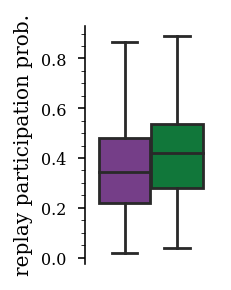

In [77]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

keep_idx = par_df.n_replays > 0
sns.boxplot(
    x="epoch",
    y="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
# sns.stripplot(
#     x="epoch",
#     y="replay_par",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df,
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("replay participation prob.")


In [131]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder

temp_df = par_df[~np.isnan(par_df["replay_fr"]) & (par_df.deepSuperficial != "middle") & (par_df.n_replays > 0)]

lbl=LabelEncoder()
temp_df['basepath_encoded'] = lbl.fit_transform(temp_df[['basepath']])
temp_df['deepSuperficial_encoded'] = lbl.fit_transform(temp_df[['deepSuperficial']])

temp_df["Intercept"] = 1
exog = temp_df[["Intercept", "deepSuperficial_encoded"]]
md = sm.MixedLM(temp_df["replay_fr"], exog, groups=temp_df["basepath_encoded"], exog_re=exog["Intercept"])
mdf = md.fit()
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    replay_fr
No. Observations:    268        Method:                REML     
No. Groups:          9          Scale:                 6.0360   
Min. group size:     14         Log-Likelihood:        -630.2250
Max. group size:     49         Converged:             Yes      
Mean group size:     29.8                                       
----------------------------------------------------------------
                        Coef. Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept               3.687    0.493 7.472 0.000  2.720  4.654
deepSuperficial_encoded 0.226    0.366 0.619 0.536 -0.490  0.943
Intercept Var           1.852    0.428                          



In [63]:
# par_df["forward_reverse_ratio"] = (
#     par_df.forward_replay_par - par_df.reverse_replay_par
# ) / (par_df.forward_replay_par + par_df.reverse_replay_par)

par_df["forward_reverse_ratio"] = (
    par_df.forward_replay_par - par_df.reverse_replay_par
)

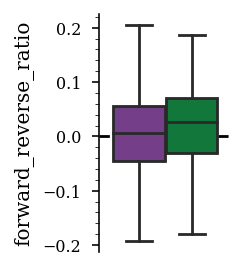

In [73]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch",
    y="forward_reverse_ratio",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
    # boxprops=dict(alpha=.7)

# sns.stripplot(
#     x="epoch",
#     y="forward_reverse_ratio",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df,
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.axhline(0, linestyle="--", color="k",zorder=-1000)

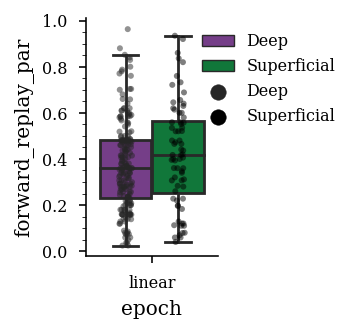

In [74]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

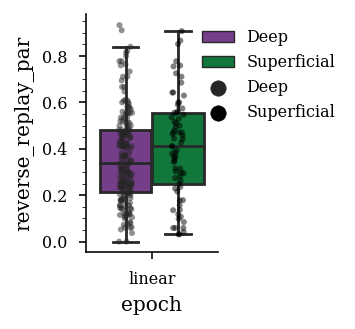

In [75]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

In [ ]:
par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_task_post.csv")
